![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/Spark_NLP_Udemy_MOOC/Open_Source/24.02.TFNerDLGraphBuilder.ipynb)

# **TFNerDLGraphBuilder**

This notebook will cover the different parameters and usages of `TFNerDLGraphBuilder`. This annotator is a pipeline component used to generate Ner DL graphs.

**📖 Learning Objectives:**

1. Being able to create graphs to train NER models using `TFNerDLGraphBuilder`.

2. Customizing the parameters of the annotator.


**🔗 Helpful Links:**

- Example of [graph generation](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/4.1_NerDL_Graph.ipynb)

- For extended examples of usage, see the [Spark NLP Workshop repository](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/4.NERDL_Training.ipynb).

## **📜 Background**


`TFNerDLGraphBuilder` annotator can be used to create graphs in the model training pipeline. This annotator inspects the data and creates the proper graph if a suitable version of TensorFlow (<= 2.7 ) is available.

This is how a graph looks like visually using [TensorBoard](https://www.tensorflow.org/tensorboard/graphs):

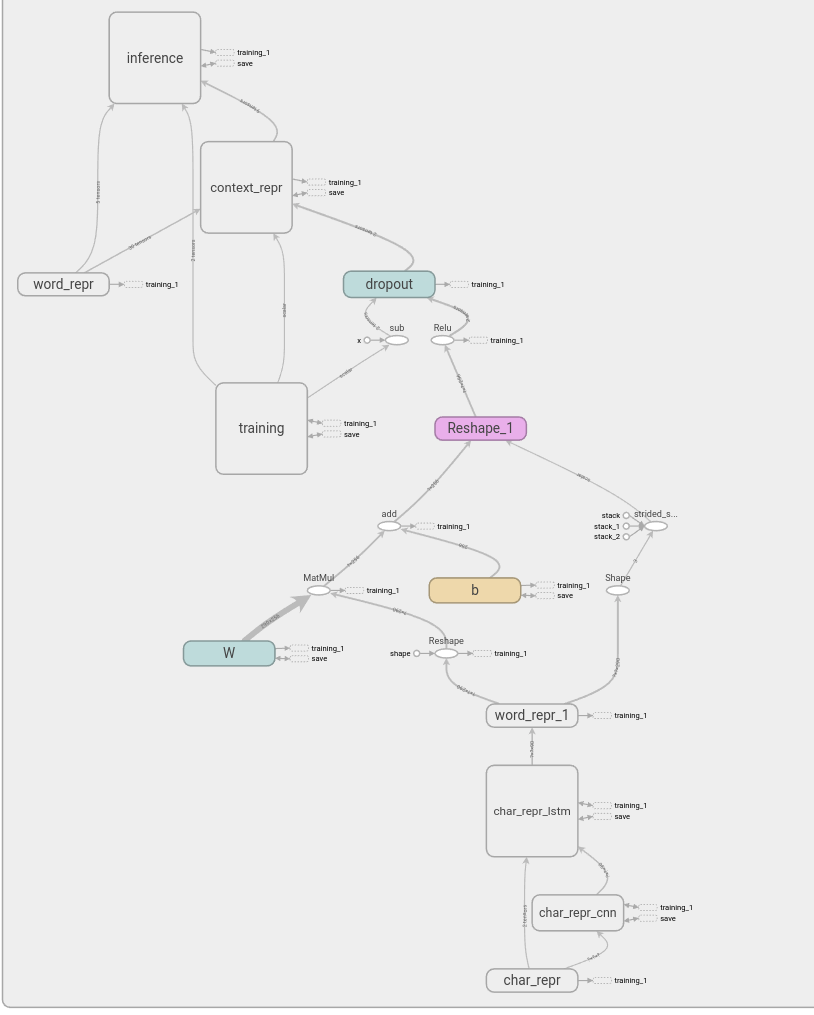

`TFNerDLGraphBuilder` is used in pipelines that include `NerDLApproach`. If you are using `MedicalNerApproach`, you can create your graph with `TFGraphBuilder` instead.

## **🎬 Colab Setup**

In [ ]:
!pip install -q pyspark==3.1.2  spark-nlp==4.2.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.4/448.4 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 14.8 MB/s eta 0:00:00


In [ ]:
!pip install -q tensorflow==2.7.0
!pip install -q tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.6/489.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 KB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:00


In [ ]:
import os
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.training import CoNLL
from pyspark.ml import Pipeline

spark = sparknlp.start()

## **🖨️ Input/Output Annotation Types**

- Input: `DOCUMENT`, `TOKEN`, `WORD_EMBEDDINGS` (and an additional label column of annotator type `NAMED_ENTITY`)

- Output: Graph for training (stored in the defined folder and loaded by the NER approach)

## **🔎 Parameters**


- `graphFolder`: (String) Folder path that contain external graph files.

- `graphFile`: (String) Graph file name. If empty, default name is generated.

- `hiddenUnitsNumber`: (Int) Size of the LSTM layer (the recurrent layer of the model). The default value is 128. Higher numbers will add more capacity to remember sequences, although if it is too big there is risk of overfitting.

## **Example**

To show how to use `TFNerDLGraphBuilder`, we are going to train an NER model using part of the CoNLL-2003 dataset. CONLL() function is used to create a PySpark dataframe with the required format for training. 

### CoNLL-2003 dataset import

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.train

In [ ]:
with open("eng.train") as f:
    train_txt =f.read()

print (train_txt[:300])

-DOCSTART- -X- -X- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER

BRUSSELS NNP B-NP B-LOC
1996-08-22 CD I-NP O

The DT B-NP O
European NNP I-NP B


In [ ]:
training_data = CoNLL().readDataset(spark, './eng.train').limit(1000)

training_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|EU rejects German...|[{document, 0, 47...|[{document, 0, 47...|[{token, 0, 1, EU...|[{pos, 0, 1, NNP,...|[{named_entity, 0...|
|     Peter Blackburn|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 4, Pe...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
| BRUSSELS 1996-08-22|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 7, BR...|[{pos, 0, 7, NNP,...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



### NER Pipeline

The NER pipeline should include a pretrained `WordEmbeddingsModel` ('glove_100d' in this example), the graph builder and the `NerDLApproach`. The same graph_folder should be used for `TFNerDLGraphBuilder` and `NerDLApproach`.

In [ ]:
!mkdir ner_logs
!mkdir ner_graphs

graph_folder = "/content/ner_graphs"

In [ ]:
glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
                      .setInputCols(["document", "token"])\
                      .setOutputCol("embeddings")

graph_builder = TFNerDLGraphBuilder()\
                      .setInputCols(["sentence", "token", "embeddings"]) \
                      .setLabelColumn("label")\
                      .setGraphFile("auto")\
                      .setGraphFolder(graph_folder)\
                      .setHiddenUnitsNumber(20)

nerTagger = NerDLApproach()\
              .setInputCols(["sentence", "token", "embeddings"])\
              .setLabelColumn("label")\
              .setOutputCol("ner")\
              .setMaxEpochs(3)\
              .setGraphFolder(graph_folder)\
              .setOutputLogsPath('ner_logs')\
              .setEnableOutputLogs(True)
    
ner_pipeline = Pipeline(stages=[glove_embeddings,
                                graph_builder,
                                nerTagger])

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


The NER model is trained using fit().

In [ ]:
ner_model = ner_pipeline.fit(training_data)

Ner DL Graph Builder configuration:
Graph folder: /content/ner_graphs
Graph file name: auto
Build params: {'ntags': 9, 'embeddings_dim': 100, 'nchars': 78, 'lstm_size': 20}


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


As the value for graphFile is "auto", the name of the graph file was automatically defined by the graph builder based on the build params (i.e. the string 'blstm_9_100_20_78.pb' includes the number of tags, embeddings dimensions, number of chars and lstm_size or hidden units number).

In [ ]:
os.listdir(graph_folder)

['blstm_9_100_20_78.pb']